In [1]:
import gzip

In [47]:
# Feature Extractions
with gzip.open('finefoods.txt.gz', 'rt', encoding='latin-1') as f:
    
    text_csv = []
    curr_review = []
    
    for idx, line in enumerate(f):
        if line == '\n':
            text_csv.append(curr_review)
            curr_review = []
            continue

        try:
            colon = line.index(':')
            field, value = line[:colon], line[colon+1:].strip()
            curr_review.append(value)
        except:
            curr_review[-1] += '\n' + line

MABEL "Tell us about yourself!
88 years old. ...

Don Snyder "The Idea Guy
...creative powers b...

Sherry "Tell us about yourself!
School Princi...

Sherry "Tell us about yourself!
School Princi...

J. Facey "J.F., CA
I am a voracious reader/li...

Sherry "Tell us about yourself!
School Princi...

Don Snyder "The Idea Guy
...creative powers b...



In [ ]:
fields = ['product/productId', 
              'review/userId', 
              'review/profileName', 
              'review/helpfulness',
              'review/score',
              'review/time',
              'review/summary',
              'review/text']
    

In [49]:
import csv

with open('finefoods.csv', 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    csv_writer.writerow(fields)
    
    csv_writer.writerows(text_csv)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set('notebook',
        font_scale=1.5,
        rc={'figure.figsize': (12, 6)})
sns.set_style('darkgrid')

In [2]:
reviews = pd.read_csv('data/finefoods.csv.gz',
                      compression='gzip')

In [3]:
matrix = reviews[['review/userId', 'product/productId', 'review/score']]
matrix = matrix.rename(columns={'review/userId': 'userId',
                       'product/productId': 'itemId',
                       'review/score': 'rating'})
matrix

,userId,itemId,rating
0,A3SGXH7AUHU8GW,B001E4KFG0,5.0
1,A1D87F6ZCVE5NK,B00813GRG4,1.0
2,ABXLMWJIXXAIN,B000LQOCH0,4.0
3,A395BORC6FGVXV,B000UA0QIQ,2.0
4,A1UQRSCLF8GW1T,B006K2ZZ7K,5.0
...,...,...,...
568449,A28KG5XORO54AY,B001EO7N10,5.0
568450,A3I8AFVPEE8KI5,B003S1WTCU,2.0
568451,A121AA1GQV751Z,B004I613EE,5.0
568452,A3IBEVCTXKNOH,B004I613EE,5.0


In [4]:
matrix['userId'].nunique()

256059

In [5]:
user_review_counts = matrix['userId'].value_counts().sort_values(ascending=False)

In [23]:
(user_review_counts < 10).sum()

248469

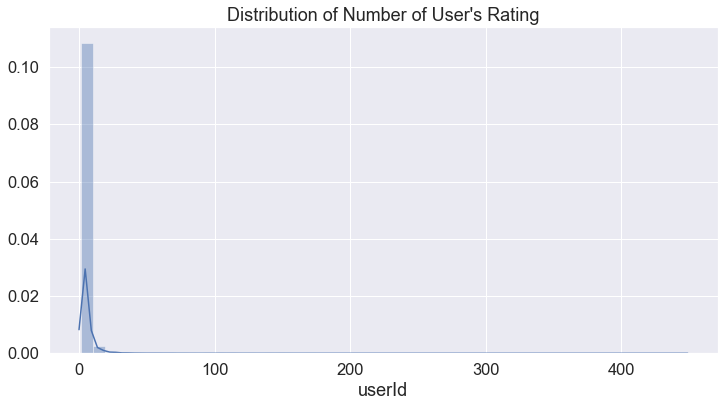

In [7]:
sns.distplot(user_review_counts)
plt.title('Distribution of Number of User\'s Rating');
plt.savefig('n_user_ratings.jpg')

In [8]:
matrix['itemId'].nunique()

74258

In [9]:
item_review_counts = matrix['itemId'].value_counts().sort_values(ascending=False)

In [26]:
(item_review_counts < 10).sum()

63639

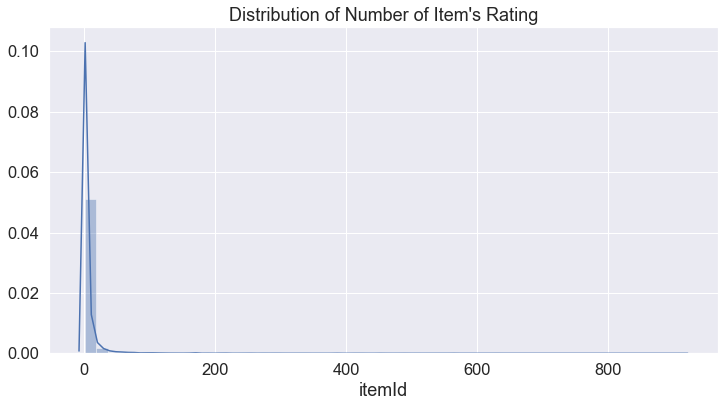

In [11]:
sns.distplot(item_review_counts)
plt.title('Distribution of Number of Item\'s Rating');
plt.savefig('n_item_ratings.jpg')

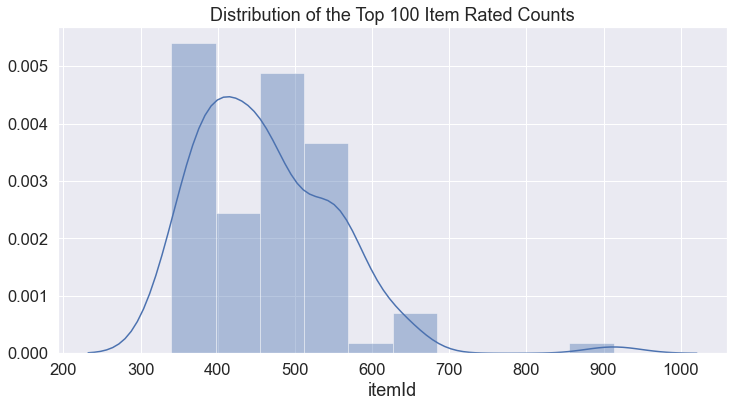

In [13]:
sns.distplot(item_review_counts.head(100))
plt.title('Distribution of the Top 100 Item Rated Counts');

In [10]:
matrix['rating'].describe()

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

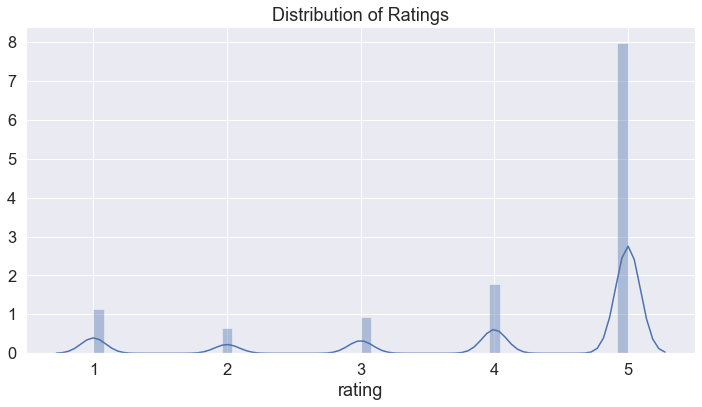

In [14]:
sns.distplot(matrix['rating'])

plt.title('Distribution of Ratings');
plt.savefig('ratings.jpg')

#### Model

In [8]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
import numpy as np

In [9]:
# Random seed

np.random.seed(42)

In [11]:
# parse file containing the ratings
reader = Reader(rating_scale=(1, 5))
# surprise base class dataset
# data = Dataset.load_from_df(matrix[['userId', 'itemId', 'rating']], reader)

In [12]:
# Grab items with more than 100 ratings
greater_than_100_ratings = matrix['itemId'].value_counts().index[matrix['itemId'].value_counts() >= 100]

# Create a matrix with those items
small_matrix = matrix[matrix['itemId'].isin(greater_than_100_ratings)]

small_data = Dataset.load_from_df(small_matrix, reader)

In [48]:
a = matrix['itemId'].value_counts()

In [54]:
a[a >= 100].index

Index(['B007JFMH8M', 'B002QWHJOU', 'B0026RQTGE', 'B002QWP8H0', 'B002QWP89S',
       'B003B3OOPA', 'B001EO5Q64', 'B006HYLW32', 'B0013NUGDE', 'B007M83302',
       ...
       'B000P52FLW', 'B001LXYA5Q', 'B000P54HVS', 'B000CQIDAG', 'B000CQBZV0',
       'B000CQIDK6', 'B002TMV34E', 'B000EVMNMI', 'B004P4TL8E', 'B000H241DS'],
      dtype='object', length=866)

In [7]:
from surprise import BaselineOnly

In [142]:
algo = BaselineOnly()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1632  1.1662  1.1697  1.1725  1.1737  1.1691  0.0039  
MAE (testset)     0.8984  0.9012  0.9027  0.9055  0.9055  0.9027  0.0027  
Fit time          2.86    3.18    2.84    2.74    2.74    2.87    0.16    
Test time         0.73    0.80    0.66    1.76    0.65    0.92    0.42    


In [6]:
from surprise import SVD

In [69]:
algo = SVD()
cross_validate(algo, small_data, measures=['rmse', 'mae'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7624  0.7641  0.7651  0.7791  0.7647  0.7671  0.0061  
MAE (testset)     0.5082  0.5110  0.5092  0.5208  0.5120  0.5122  0.0045  
Fit time          9.13    9.61    9.41    9.26    9.64    9.41    0.20    
Test time         0.32    0.33    0.44    0.38    0.31    0.35    0.05    


In [66]:
from surprise import SVDpp

In [68]:
algo = SVDpp()
cross_validate(algo, small_data, measures=['rmse', 'mae'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7253  0.7280  0.7306  0.7363  0.7304  0.7301  0.0036  
MAE (testset)     0.4565  0.4600  0.4650  0.4678  0.4669  0.4632  0.0043  
Fit time          29.83   58.57   37.44   34.16   32.31   38.46   10.35   
Test time         2.08    0.84    0.79    0.90    0.90    1.10    0.49    


In [9]:
from surprise import NMF

In [146]:
algo = NMF()
cross_validate(algo, data, measures=['rmse', 'mae'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1449  1.1567  1.1448  1.1492  1.1484  1.1488  0.0043  
MAE (testset)     0.8174  0.8254  0.8159  0.8170  0.8189  0.8189  0.0034  
Fit time          59.11   57.38   56.98   57.34   57.15   57.59   0.77    
Test time         0.88    1.94    0.86    0.84    0.85    1.07    0.44    


In [4]:
from surprise import KNNBaseline, KNNBasic, KNNWithMeans

In [27]:
# Random sample data
matrix_sample = matrix.sample(n=int(matrix.shape[0]/20), random_state=42)
data_sample = Dataset.load_from_df(matrix_sample, reader)

In [71]:
sim_options = {'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
cross_validate(algo, small_data, measures=['rmse', 'mae'], cv=5, verbose=True);

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6560  0.6536  0.6498  0.6486  0.6559  0.6528  0.0031  
MAE (testset)     0.3083  0.3069  0.3053  0.3053  0.3103  0.3072  0.0019  
Fit time          0.69    0.70    1.06    0.67    0.79    0.78    0.15    
Test time         0.92    0.90    1.12    1.34    0.87    1.03    0.18    


In [78]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
cross_validate(algo, small_data, measures=['rmse', 'mae'], cv=5, verbose=True);

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6758  0.6684  0.6807  0.6794  0.6672  0.6743  0.0056  
MAE (testset)     0.3239  0.3224  0.3293  0.3278  0.3211  0.3249  0.0032  
Fit time          0.85    0.85    0.87    0.77    0.76    0.82    0.05    
Test time         1.42    0.93    1.02    1.06    1.61    1.21    0.26    


#### Hyperparameter search on SVD

In [80]:
from surprise.model_selection import RandomizedSearchCV

In [81]:
param_grid = {'n_factors': range(10, 101),
              'n_epochs': range(20, 41),
              'lr_all': np.linspace(5e-3, 5e-1, num=10),
              'reg_all': np.linspace(2e-2, 1e-1, num=10)}

rs = RandomizedSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

rs.fit(small_data)

In [82]:
print(rs.best_score['rmse'])
rs.best_params['rmse']

0.6542315448884888


{'n_factors': 82, 'n_epochs': 33, 'lr_all': 0.115, 'reg_all': 0.02}

#### Hyperparameter search on KNN

In [83]:
param_grid = {'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'min_support': range(1, 6),
                              'user_based': [False]},
              'k': range(30, 61, 5),
              'min_k': range(1, 11)}

rs = RandomizedSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

rs.fit(small_data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [84]:
print(rs.best_score['rmse'])
rs.best_params['rmse']

0.6691366059802691


{'sim_options': {'name': 'pearson', 'min_support': 4, 'user_based': False},
 'k': 35,
 'min_k': 1}

#### Train on full dataset for prediction

#### SVD

In [13]:
best_params = {'n_factors': 82, 'n_epochs': 33, 'lr_all': 0.115, 'reg_all': 0.02}
algo = SVD(**best_params)
trainset = small_data.build_full_trainset()
algo.fit(trainset)

In [60]:
testset = trainset.build_anti_testset()

In [13]:
predictions = [algo.predict(user, item) for user, item, _ in filter(lambda x: x[0] == 'A2NO1TXXS9T0EE', testset)]
top_n = [(i, est) for u, i, true_r, est, _ in predictions]
sorted(top_n, key=lambda x: x[1], reverse=True)[:10]

[('B000ET4SM8', 4.6742048925104145),
 ('B001L4JH5I', 4.660383060248657),
 ('B000O5DI1E', 4.6568253791785095),
 ('B000DZDJ0K', 4.590652183249116),
 ('B000ED9L9E', 4.586000147604597),
 ('B006J4MAIQ', 4.537794522331957),
 ('B007R900WA', 4.5333626652321195),
 ('B006J4MAUE', 4.532288184443564),
 ('B000FKQD42', 4.5277823848086305),
 ('B007JFMH8M', 4.511815567537025)]

In [ ]:
%%timeit
ttt = trainset.build_anti_testset()

#### KNN

In [20]:
trainset.all_users()

range(0, 50267)

In [15]:
best_params = {'sim_options': {'name': 'pearson', 'min_support': 4, 'user_based': False},
 'k': 35,
 'min_k': 1}

algo = KNNBaseline(**best_params)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


<generator object Trainset.all_ratings at 0x1a44836a98>

In [18]:
[algo.trainset.to_raw_iid(n) for n in algo.get_neighbors(0, 10)]

['B007TJGZ5E',
 'B003JA5KLM',
 'B001J9QBU4',
 'B007PA32OE',
 'B000H7LVKY',
 'B0051COPH6',
 'B001HN5Z4K',
 'B0058AMY74',
 'B0012XBD7I',
 'B000G6MBUA']

#### Dumping algorithm

In [19]:
from surprise import dump

#### SVD dump

In [20]:
best_params = {'n_factors': 82, 'n_epochs': 33, 'lr_all': 0.115, 'reg_all': 0.02}
algo = SVD(**best_params)
trainset = small_data.build_full_trainset()
algo.fit(trainset)

testset = trainset.build_anti_testset() #Put anti testset in postgres

In [29]:
dump.dump('svd_algo.dump', algo=algo)

#### KNN dump

In [34]:
best_params = {'sim_options': {'name': 'pearson', 'min_support': 4, 'user_based': False},
 'k': 35,
 'min_k': 1}

algo = KNNBaseline(**best_params)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [35]:
dump.dump('knn_algo.dump', algo=algo)